In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Load the dataset

In [38]:
# Load the dataset
data = pd.read_csv('Dead by Daylight data.csv')
data.head()

,Map,Killer,Nb Finished generators,Nb Escaped Survivors,Comments,Nb Hatch escapes,Season,SBMM
0,BAP,Deathslinger,5,4,NaN,0,February,False
1,MCM,Cannibal,2,0,NaN,0,February,False
2,SH,Huntress,5,4,Farm,0,February,False
3,CF,Myers,3,0,Mori,0,February,False
4,AVW,Hillbilly,5,4,1 hatch,1,February,False


## Correlation study

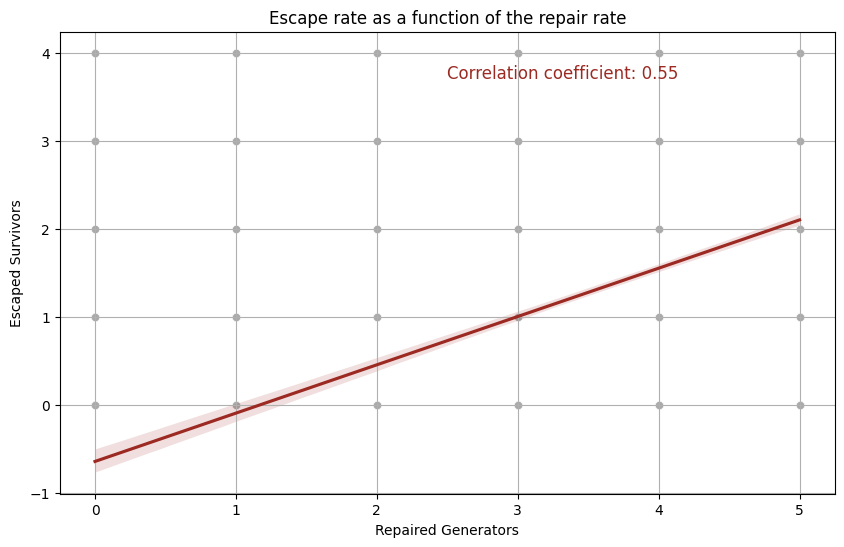

In [23]:
# Fit a linear regression model to get the slope
X = data['Nb Finished generators'].values.reshape(-1, 1)
y = data['Nb Escaped Survivors'].values
reg = LinearRegression().fit(X, y)
slope = reg.coef_[0]

# Create a scatter plot with a linear regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Nb Finished generators', y='Nb Escaped Survivors', data=data, color='darkgray')
sns.regplot(x='Nb Finished generators', y='Nb Escaped Survivors', data=data, scatter=False, color='#9C2A23')

# Add grid
plt.grid(True)

# Add labels and title
plt.xlabel('Repaired Generators')
plt.ylabel('Escaped Survivors')
plt.title('Escape rate as a function of the repair rate')

# Annotate the plot with the slope value
plt.text(0.5, 0.9, f'Correlation coefficient: {slope:.2f}', transform=plt.gca().transAxes, fontsize=12, color='#9C2A23')

# Display the plot
plt.show()


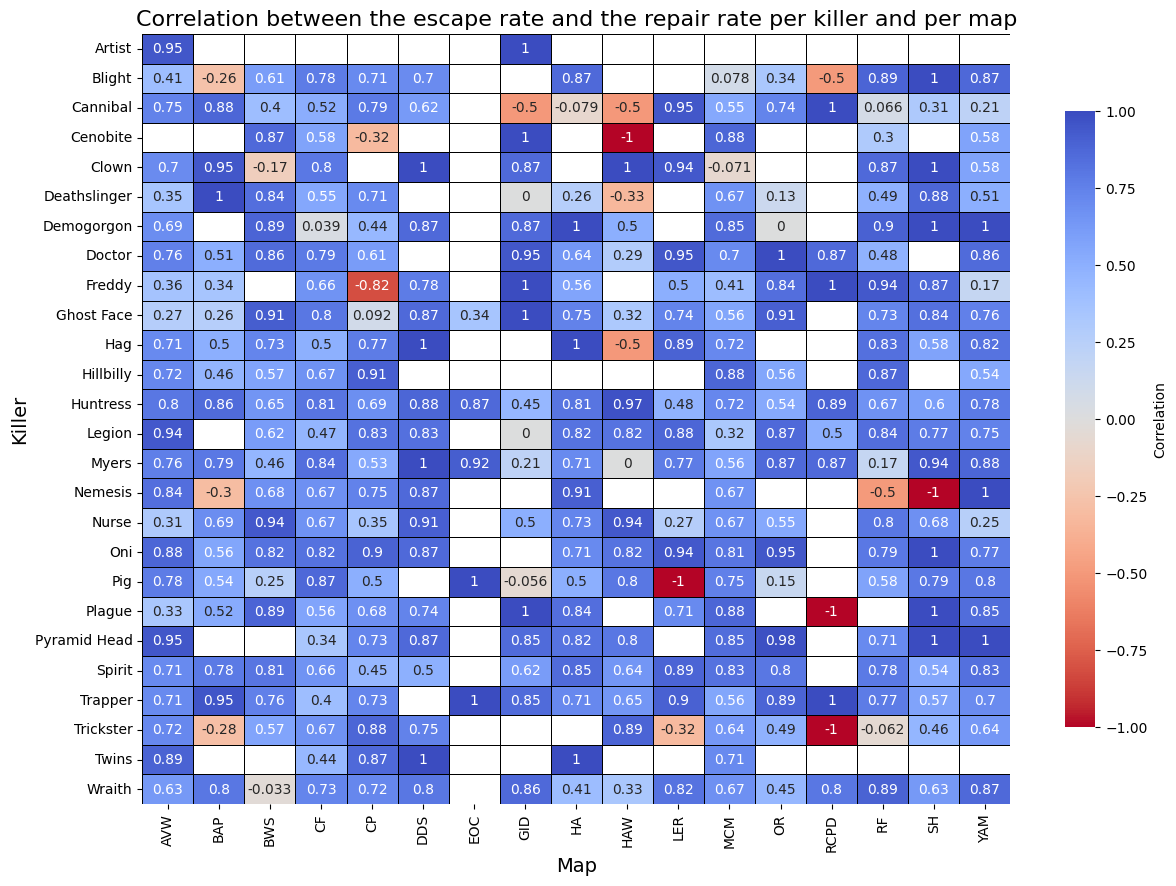

In [18]:
# Standardize the map names by stripping leading/trailing whitespace
data['Map'] = data['Map'].str.strip()

# Calculate Spearman correlation for each Killer and Map
cor_data = data.groupby(['Killer', 'Map']).apply(
    lambda group: pd.Series({
        'Correlation': group['Nb Finished generators'].corr(group['Nb Escaped Survivors'], method='spearman')
    })
).reset_index()

# Create a pivot table for the heatmap
cor_pivot = cor_data.pivot(index='Killer', columns='Map', values='Correlation')

# Plotting the heatmap
plt.figure(figsize=(14, 10))
ax = sns.heatmap(cor_pivot, annot=True, cmap='coolwarm_r', center=0, 
                 cbar_kws={'label': 'Correlation', 'orientation': 'vertical', 'shrink': 0.8},
                 linewidths=.5, linecolor='black')

# Customize the plot
ax.set_title('Correlation between the escape rate and the repair rate per killer and per map', fontsize=16)
ax.set_xlabel('Map', fontsize=14)
ax.set_ylabel('Killer', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Add a grid
ax.set_yticks([i + 0.5 for i in range(len(cor_pivot))], minor=True)
ax.set_xticks([i + 0.5 for i in range(len(cor_pivot.columns))], minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
ax.tick_params(which='minor', size=0)

# Display the plot
plt.show()



## Escapes Prediction

Mean Squared Error: 1.2065972222222223
R^2 Score: 0.3659391883223333
Given features: 
    Map  Killer  Nb Finished generators
471  CP  Spirit                       3
Predicted number of survivors escaping for this round: 0.0
Actual number of survivors escaping for this round: 1


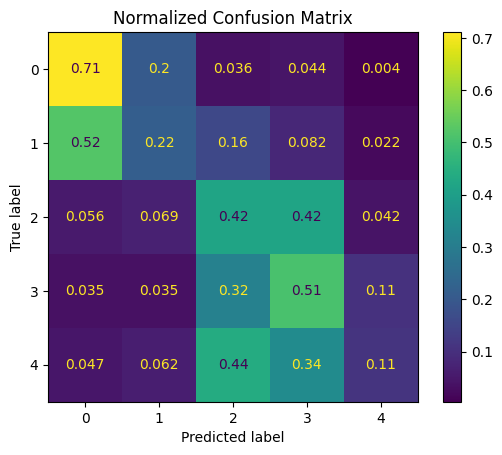

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       249
           1       0.32      0.22      0.26       134
           2       0.28      0.42      0.34        72
           3       0.28      0.51      0.36        57
           4       0.35      0.11      0.17        64

    accuracy                           0.47       576
   macro avg       0.38      0.39      0.37       576
weighted avg       0.48      0.47      0.46       576

In total 304 mistakes out of 576 samples


100%|██████████| 304/304 [00:00<00:00, 8865.29it/s]

Mistake 1:
Features: 
Map                           CP
Killer                    Spirit
Nb Finished generators         3
Name: 471, dtype: object
Actual: 1, Predicted: 0.0
--------------------------------------------------
Mistake 2:
Features: 
Map                           CF
Killer                    Wraith
Nb Finished generators         5
Name: 1453, dtype: object
Actual: 2, Predicted: 3.0
--------------------------------------------------
Mistake 3:
Features: 
Map                             SH
Killer                    Huntress
Nb Finished generators           5
Name: 2377, dtype: object
Actual: 0, Predicted: 3.0
--------------------------------------------------
Mistake 4:
Features: 
Map                          MCM
Killer                    Freddy
Nb Finished generators         5
Name: 1094, dtype: object
Actual: 4, Predicted: 2.0
--------------------------------------------------
Mistake 5:
Features: 
Map                           OR
Killer                    Spirit
Nb Finished

In [49]:
# Load the dataset
data = pd.read_csv('Dead by Daylight data.csv')

# Define features and target
features = data.drop(columns=['Nb Escaped Survivors', 'Comments', 'Nb Hatch escapes', 'SBMM', 'Season'])
target = data['Nb Escaped Survivors']

# Identify categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test).round().clip(0, 4)  # to have an integer between 0 and 4 as output

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Example prediction
example = X_test.iloc[0:1]
predicted_escapees = model.predict(example).round().clip(0, 4)
actual_escapees = y_test.iloc[0]
print(f'Given features: \n{example}')
print(f'Predicted number of survivors escaping for this round: {predicted_escapees[0]}')
print(f'Actual number of survivors escaping for this round: {actual_escapees}')

# Confusion Matrix
class_names = np.arange(0, 5)
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=class_names)
disp.plot(cmap='viridis')
plt.title('Normalized Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Save the model
#joblib.dump(model, 'dbd_survivor_prediction_model.pkl')


from tqdm import tqdm
# Error analysis
err = []
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        err.append(i)

print(f'In total {len(err)} mistakes out of {len(y_test)} samples')

for i in tqdm(range(len(err))):
    index = err[i]
    print(f'Mistake {i+1}:')
    print(f'Features: \n{X_test.iloc[index]}')
    print(f'Actual: {y_test.iloc[index]}, Predicted: {y_pred[index]}')
    print('-' * 50)


## Exit Gate Escapes (only!) Prediction

Mean Squared Error: 1.1006944444444444
R^2 Score: 0.46811770668872754
Given features: 
    Map  Killer  Nb Finished generators
471  CP  Spirit                       3
Predicted number of survivors escaping through exit gates for this round: 0.0
Actual number of survivors escaping through exit gates for this round: 0


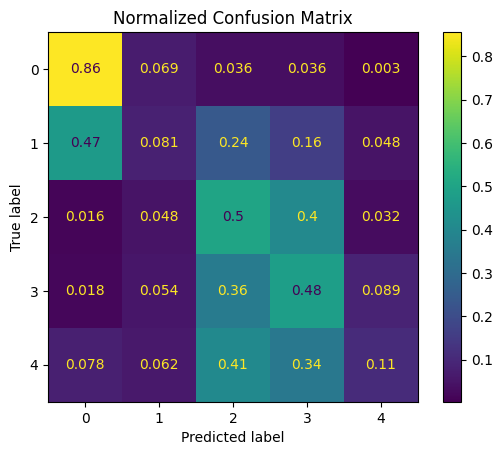

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       332
           1       0.13      0.08      0.10        62
           2       0.30      0.50      0.37        62
           3       0.28      0.48      0.36        56
           4       0.39      0.11      0.17        64

    accuracy                           0.61       576
   macro avg       0.40      0.41      0.37       576
weighted avg       0.63      0.61      0.61       576

In total 222 mistakes out of 576 samples


100%|██████████| 222/222 [00:00<00:00, 9233.88it/s]

Mistake 1:
Features: 
Map                           CF
Killer                    Wraith
Nb Finished generators         5
Name: 1453, dtype: object
Actual: 2, Predicted: 3.0
--------------------------------------------------
Mistake 2:
Features: 
Map                             SH
Killer                    Huntress
Nb Finished generators           5
Name: 2377, dtype: object
Actual: 0, Predicted: 3.0
--------------------------------------------------
Mistake 3:
Features: 
Map                          MCM
Killer                    Freddy
Nb Finished generators         5
Name: 1094, dtype: object
Actual: 4, Predicted: 2.0
--------------------------------------------------
Mistake 4:
Features: 
Map                          GID
Killer                    Wraith
Nb Finished generators         5
Name: 368, dtype: object
Actual: 4, Predicted: 2.0
--------------------------------------------------
Mistake 5:
Features: 
Map                         BAP
Killer                    Clown
Nb Finished g

In [48]:
# Load the dataset
data = pd.read_csv('Dead by Daylight data.csv')

# Create the new target variable: number of survivors escaping through exit gates
data['Nb Exit Gate Escapes'] = data['Nb Escaped Survivors'] - data['Nb Hatch escapes']

# Define features and target
features = data.drop(columns=['Nb Escaped Survivors', 'Nb Hatch escapes', 'Comments', 'SBMM', 'Season', 'Nb Exit Gate Escapes'])
target = data['Nb Exit Gate Escapes']

# Identify categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = np.round(model.predict(X_test)).clip(0, 4)  # to have an integer between 0 and 4 as output

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Example prediction
example = X_test.iloc[0:1]
predicted_exit_gate_escapes = np.round(model.predict(example)).clip(0, 4)
actual_exit_gate_escapes = y_test.iloc[0]
print(f'Given features: \n{example}')
print(f'Predicted number of survivors escaping through exit gates for this round: {predicted_exit_gate_escapes[0]}')
print(f'Actual number of survivors escaping through exit gates for this round: {actual_exit_gate_escapes}')

# Confusion Matrix
class_names = np.arange(0, 5)
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=class_names)
disp.plot(cmap='viridis')
plt.title('Normalized Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Save the model
#joblib.dump(model, 'dbd_exit_gate_escape_prediction_model.pkl')


from tqdm import tqdm
# Error analysis
err = []
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        err.append(i)

print(f'In total {len(err)} mistakes out of {len(y_test)} samples')

for i in tqdm(range(len(err))):
    index = err[i]
    print(f'Mistake {i+1}:')
    print(f'Features: \n{X_test.iloc[index]}')
    print(f'Actual: {y_test.iloc[index]}, Predicted: {y_pred[index]}')
    print('-' * 50)


## Exit Gates (only!) escapes prediction with 'Killer DC' filtering

Mean Squared Error: 1.0371681415929204
R^2 Score: 0.5203512797779439
Given features: 
     Map Killer  Nb Finished generators
1112  SH  Myers                       5
Predicted number of survivors escaping through exit gates for this round: 3.0
Actual number of survivors escaping through exit gates for this round: 3


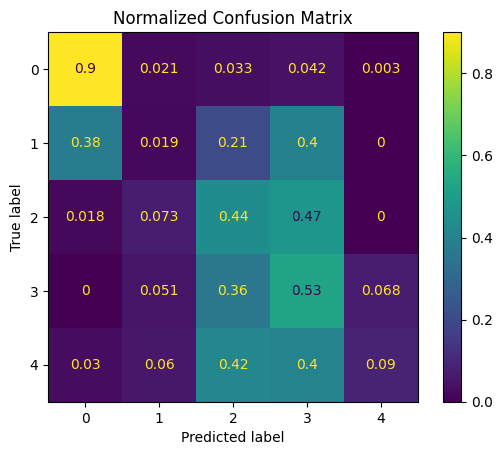

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       331
           1       0.05      0.02      0.03        53
           2       0.25      0.44      0.32        55
           3       0.26      0.53      0.35        59
           4       0.55      0.09      0.15        67

    accuracy                           0.64       565
   macro avg       0.41      0.39      0.35       565
weighted avg       0.67      0.64      0.62       565

In total 205 mistakes out of 565 samples


100%|██████████| 205/205 [00:00<00:00, 7486.89it/s]

Mistake 1:
Features: 
Map                             SH
Killer                    Huntress
Nb Finished generators           5
Name: 2377, dtype: object
Actual: 0, Predicted: 3.0
--------------------------------------------------
Mistake 2:
Features: 
Map                          AVW
Killer                    Artist
Nb Finished generators         5
Name: 2645, dtype: object
Actual: 2, Predicted: 3.0
--------------------------------------------------
Mistake 3:
Features: 
Map                           OR
Killer                    Blight
Nb Finished generators         5
Name: 1126, dtype: object
Actual: 4, Predicted: 2.0
--------------------------------------------------
Mistake 4:
Features: 
Map                            BWS
Killer                    Huntress
Nb Finished generators           5
Name: 1397, dtype: object
Actual: 2, Predicted: 3.0
--------------------------------------------------
Mistake 5:
Features: 
Map                             MCM
Killer                    Trickste

In [47]:
# Filter out matches where 'Comments' contains 'Killer DC'
data = data[~data['Comments'].str.contains('Killer DC', na=False)]

# Create the new target variable: number of survivors escaping through exit gates
data['Nb Exit Gate Escapes'] = data['Nb Escaped Survivors'] - data['Nb Hatch escapes']

# Define features and target
features = data.drop(columns=['Nb Escaped Survivors', 'Nb Hatch escapes', 'Comments', 'SBMM', 'Season', 'Nb Exit Gate Escapes'])
target = data['Nb Exit Gate Escapes']

# Identify categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = np.round(model.predict(X_test)).clip(0, 4)  # to have an integer between 0 and 4 as output

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Example prediction
example = X_test.iloc[0:1]
predicted_exit_gate_escapes = np.round(model.predict(example)).clip(0, 4)
actual_exit_gate_escapes = y_test.iloc[0]
print(f'Given features: \n{example}')
print(f'Predicted number of survivors escaping through exit gates for this round: {predicted_exit_gate_escapes[0]}')
print(f'Actual number of survivors escaping through exit gates for this round: {actual_exit_gate_escapes}')

# Confusion Matrix
class_names = np.arange(0, 5)
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=class_names)
disp.plot(cmap='viridis')
plt.title('Normalized Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Save the model
#joblib.dump(model, 'dbd_exit_gate_escape_prediction_model_no_killer_dc.pkl')

# Error analysis
err = []
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        err.append(i)

print(f'In total {len(err)} mistakes out of {len(y_test)} samples')

for i in tqdm(range(len(err))):
    index = err[i]
    print(f'Mistake {i+1}:')
    print(f'Features: \n{X_test.iloc[index]}')
    print(f'Actual: {y_test.iloc[index]}, Predicted: {y_pred[index]}')
    print('-' * 50)


## Exit Gates (only!) escapes prediction with 'Killer DC' filtering using SVM

Mean Squared Error: 0.9451327433628318
R^2 Score: 0.562913964848843
Given features: 
     Map Killer  Nb Finished generators
1112  SH  Myers                       5
Predicted number of survivors escaping through exit gates for this round: 3.0
Actual number of survivors escaping through exit gates for this round: 3


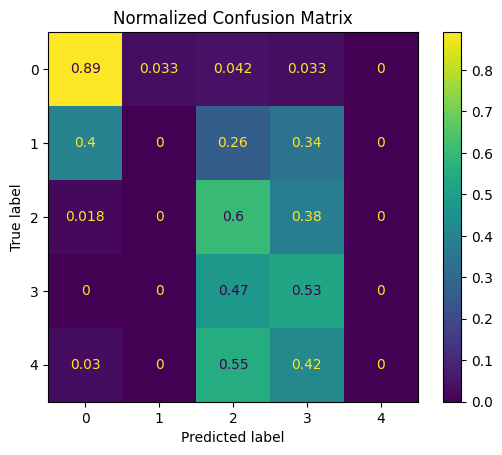

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       331
           1       0.00      0.00      0.00        53
           2       0.26      0.60      0.36        55
           3       0.28      0.53      0.37        59
           4       0.00      0.00      0.00        67

    accuracy                           0.64       565
   macro avg       0.29      0.40      0.33       565
weighted avg       0.60      0.64      0.61       565

In total 206 mistakes out of 565 samples


100%|██████████| 206/206 [00:00<00:00, 9238.85it/s]

Mistake 1:
Features: 
Map                             SH
Killer                    Huntress
Nb Finished generators           5
Name: 2377, dtype: object
Actual: 0, Predicted: 3.0
--------------------------------------------------
Mistake 2:
Features: 
Map                          AVW
Killer                    Artist
Nb Finished generators         5
Name: 2645, dtype: object
Actual: 2, Predicted: 3.0
--------------------------------------------------
Mistake 3:
Features: 
Map                           OR
Killer                    Blight
Nb Finished generators         5
Name: 1126, dtype: object
Actual: 4, Predicted: 2.0
--------------------------------------------------
Mistake 4:
Features: 
Map                            BWS
Killer                    Huntress
Nb Finished generators           5
Name: 1397, dtype: object
Actual: 2, Predicted: 3.0
--------------------------------------------------
Mistake 5:
Features: 
Map                             MCM
Killer                    Trickste

In [46]:
# Filter out matches where 'Comments' contains 'Killer DC'
data = data[~data['Comments'].str.contains('Killer DC', na=False)]

# Create the new target variable: number of survivors escaping through exit gates
data['Nb Exit Gate Escapes'] = data['Nb Escaped Survivors'] - data['Nb Hatch escapes']

# Define features and target
features = data.drop(columns=['Nb Escaped Survivors', 'Nb Hatch escapes', 'Comments', 'SBMM', 'Season', 'Nb Exit Gate Escapes'])
target = data['Nb Exit Gate Escapes']

# Identify categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), features.select_dtypes(include=['number']).columns.tolist())
    ],
    remainder='passthrough'
)

# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel='rbf', C=1.0, epsilon=0.1)) #radial basis function kernel
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = np.round(model.predict(X_test)).clip(0, 4)  # to have an integer between 0 and 4 as output

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Example prediction
example = X_test.iloc[0:1]
predicted_exit_gate_escapes = np.round(model.predict(example)).clip(0, 4)
actual_exit_gate_escapes = y_test.iloc[0]
print(f'Given features: \n{example}')
print(f'Predicted number of survivors escaping through exit gates for this round: {predicted_exit_gate_escapes[0]}')
print(f'Actual number of survivors escaping through exit gates for this round: {actual_exit_gate_escapes}')

# Confusion Matrix
class_names = np.arange(0, 5)
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=class_names)
disp.plot(cmap='viridis')
plt.title('Normalized Confusion Matrix')
plt.show()
# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Save the model
#joblib.dump(model, 'dbd_exit_gate_escape_prediction_model_no_killer_dc_svm.pkl')

# Error analysis
err = []
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        err.append(i)

print(f'In total {len(err)} mistakes out of {len(y_test)} samples')

for i in tqdm(range(len(err))):
    index = err[i]
    print(f'Mistake {i+1}:')
    print(f'Features: \n{X_test.iloc[index]}')
    print(f'Actual: {y_test.iloc[index]}, Predicted: {y_pred[index]}')
    print('-' * 50)


## Exit Gates (only!) escapes prediction with 'Killer DC' filtering using SVM (with Grid Search)

Best parameters: {'regressor__C': 1, 'regressor__gamma': 'scale', 'regressor__kernel': 'rbf'}
Best score: 0.6177529138585532
Mean Squared Error: 0.9451327433628318
R^2 Score: 0.562913964848843
Given features: 
     Map Killer  Nb Finished generators
1112  SH  Myers                       5
Predicted number of survivors escaping through exit gates for this round: 3.0
Actual number of survivors escaping through exit gates for this round: 3


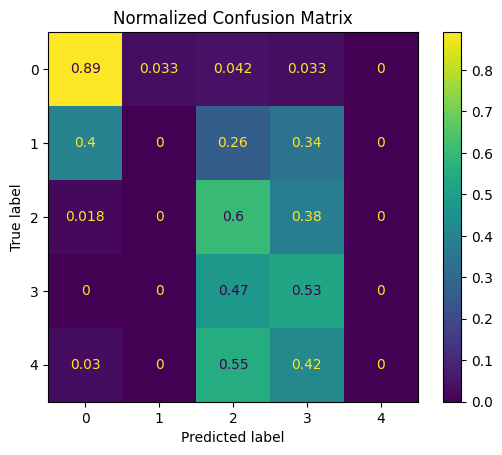

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       331
           1       0.00      0.00      0.00        53
           2       0.26      0.60      0.36        55
           3       0.28      0.53      0.37        59
           4       0.00      0.00      0.00        67

    accuracy                           0.64       565
   macro avg       0.29      0.40      0.33       565
weighted avg       0.60      0.64      0.61       565

In total 206 mistakes out of 565 samples


100%|██████████| 206/206 [00:00<00:00, 9943.91it/s]

Mistake 1:
Features: 
Map                             SH
Killer                    Huntress
Nb Finished generators           5
Name: 2377, dtype: object
Actual: 0, Predicted: 3.0
--------------------------------------------------
Mistake 2:
Features: 
Map                          AVW
Killer                    Artist
Nb Finished generators         5
Name: 2645, dtype: object
Actual: 2, Predicted: 3.0
--------------------------------------------------
Mistake 3:
Features: 
Map                           OR
Killer                    Blight
Nb Finished generators         5
Name: 1126, dtype: object
Actual: 4, Predicted: 2.0
--------------------------------------------------
Mistake 4:
Features: 
Map                            BWS
Killer                    Huntress
Nb Finished generators           5
Name: 1397, dtype: object
Actual: 2, Predicted: 3.0
--------------------------------------------------
Mistake 5:
Features: 
Map                             MCM
Killer                    Trickste

In [45]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Filter out matches where 'Comments' contains 'Killer DC'
data = data[~data['Comments'].str.contains('Killer DC', na=False)]

# Create the new target variable: number of survivors escaping through exit gates
data['Nb Exit Gate Escapes'] = data['Nb Escaped Survivors'] - data['Nb Hatch escapes']

# Define features and target
features = data.drop(columns=['Nb Escaped Survivors', 'Nb Hatch escapes', 'Comments', 'SBMM', 'Season', 'Nb Exit Gate Escapes'])
target = data['Nb Exit Gate Escapes']

# Identify categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), features.select_dtypes(include=['number']).columns.tolist())
    ],
    remainder='passthrough'
)

# Define the model pipeline with SVR
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define parameter grid for GridSearchCV
param_grid = {
    'regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'regressor__C': [0.1, 1, 10, 100],
    'regressor__gamma': ['scale', 'auto']
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Output the best parameters and score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

# Use the best estimator to make predictions
best_model = grid_search.best_estimator_
y_pred = np.round(best_model.predict(X_test)).clip(0, 4)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Example prediction
example = X_test.iloc[0:1]
predicted_exit_gate_escapes = np.round(best_model.predict(example)).clip(0, 4)
actual_exit_gate_escapes = y_test.iloc[0]
print(f'Given features: \n{example}')
print(f'Predicted number of survivors escaping through exit gates for this round: {predicted_exit_gate_escapes[0]}')
print(f'Actual number of survivors escaping through exit gates for this round: {actual_exit_gate_escapes}')

# Confusion Matrix
class_names = np.arange(0, 5)
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=class_names)
disp.plot(cmap='viridis')
plt.title('Normalized Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Save the model
#joblib.dump(best_model, 'dbd_exit_gate_escape_prediction_model_no_killer_dc_svm_best.pkl')

# Error analysis
err = []
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        err.append(i)

print(f'In total {len(err)} mistakes out of {len(y_test)} samples')

for i in tqdm(range(len(err))):
    index = err[i]
    print(f'Mistake {i+1}:')
    print(f'Features: \n{X_test.iloc[index]}')
    print(f'Actual: {y_test.iloc[index]}, Predicted: {y_pred[index]}')
    print('-' * 50)


### SVC (Classification and not Reegressions)

Best parameters: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Best score: nan
Accuracy: 0.6654867256637168
Given features: 
     Map Killer  Nb Finished generators
1112  SH  Myers                       5
Predicted number of survivors escaping through exit gates for this round: 2
Actual number of survivors escaping through exit gates for this round: 3


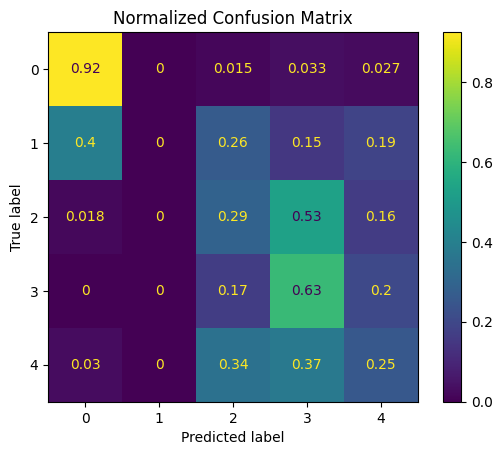

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       331
           1       0.00      0.00      0.00        53
           2       0.24      0.29      0.26        55
           3       0.34      0.63      0.44        59
           4       0.30      0.25      0.27        67

    accuracy                           0.67       565
   macro avg       0.36      0.42      0.38       565
weighted avg       0.64      0.67      0.65       565



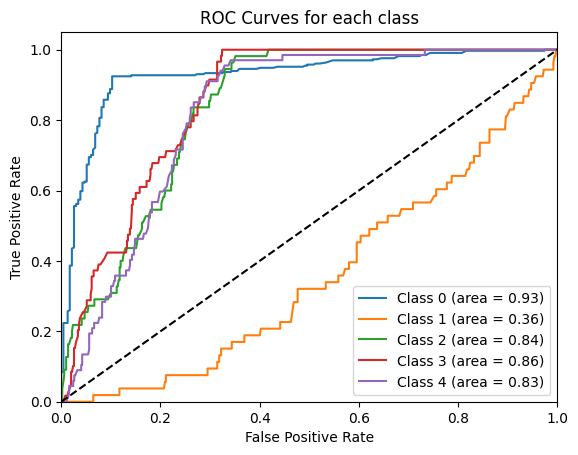

In total 189 mistakes out of 565 samples


100%|██████████| 189/189 [00:00<00:00, 8641.92it/s]

Mistake 1:
Features: 
Map                          SH
Killer                    Myers
Nb Finished generators        5
Name: 1112, dtype: object
Actual: 3, Predicted: 2
--------------------------------------------------
Mistake 2:
Features: 
Map                             SH
Killer                    Huntress
Nb Finished generators           5
Name: 2377, dtype: object
Actual: 0, Predicted: 4
--------------------------------------------------
Mistake 3:
Features: 
Map                          AVW
Killer                    Artist
Nb Finished generators         5
Name: 2645, dtype: object
Actual: 2, Predicted: 3
--------------------------------------------------
Mistake 4:
Features: 
Map                           OR
Killer                    Blight
Nb Finished generators         5
Name: 1126, dtype: object
Actual: 4, Predicted: 3
--------------------------------------------------
Mistake 5:
Features: 
Map                            BWS
Killer                    Huntress
Nb Finished gener

In [44]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV

# Load the dataset
data = pd.read_csv('Dead by Daylight data.csv')

# Filter out matches where 'Comments' contains 'Killer DC'
data = data[~data['Comments'].str.contains('Killer DC', na=False)]

# Create the new target variable: number of survivors escaping through exit gates
data['Nb Exit Gate Escapes'] = data['Nb Escaped Survivors'] - data['Nb Hatch escapes']

# Define features and target
features = data.drop(columns=['Nb Escaped Survivors', 'Nb Hatch escapes', 'Comments', 'SBMM', 'Season', 'Nb Exit Gate Escapes'])
target = data['Nb Exit Gate Escapes']

# Identify categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), features.select_dtypes(include=['number']).columns.tolist())
    ],
    remainder='passthrough'
)

# Define the model pipeline with SVC
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': ['scale', 'auto']
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_samples')
grid_search.fit(X_train, y_train)

# Output the best parameters and score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

# Use the best estimator to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Example prediction
example = X_test.iloc[0:1]
predicted_exit_gate_escapes = best_model.predict(example)
actual_exit_gate_escapes = y_test.iloc[0]
print(f'Given features: \n{example}')
print(f'Predicted number of survivors escaping through exit gates for this round: {predicted_exit_gate_escapes[0]}')
print(f'Actual number of survivors escaping through exit gates for this round: {actual_exit_gate_escapes}')

# Confusion Matrix
class_names = np.arange(0, 5)
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=class_names)
disp.plot(cmap='viridis')
plt.title('Normalized Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Save the model
#joblib.dump(best_model, 'dbd_exit_gate_escape_prediction_model_no_killer_dc_svc_best.pkl')

# ROC Curves for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in class_names:
    fpr[i], tpr[i], _ = roc_curve(y_test == i, best_model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in class_names:
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for each class')
plt.legend(loc="lower right")
plt.show()

# Error analysis
err = []
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        err.append(i)

print(f'In total {len(err)} mistakes out of {len(y_test)} samples')

for i in tqdm(range(len(err))):
    index = err[i]
    print(f'Mistake {i+1}:')
    print(f'Features: \n{X_test.iloc[index]}')
    print(f'Actual: {y_test.iloc[index]}, Predicted: {y_pred[index]}')
    print('-' * 50)


Predict a loss or a win!!

Normalize data before confusion matrix 

PCA

Add performance analysis